# Streaming Tokens

In this example we will focus on explaining how to stream tokens from a language model that is powering an agent. We will use a chat agent executor as an example. There a few specific things we need to do in order to properly stream tokens. They are: 

1. Set `streaming=True` when creating the LLM
2. Create nodes with [async methods](./async.ipynb) - this is best practice because in order to stream tokens we will use the `async_log` method.

we will call them out with the **STREAMING** tag below (if you just want to search for those).

## Setup

First we need to install the packages required

In [ ]:
!pip install --quiet -U langchain langchain_openai tavily-python

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [16]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key:········
Tavily API Key:········


Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [14]:
os.environ["LANGCHAIN_TRACING_V2"] = "True"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

LangSmith API Key:········


In [ ]:
os.environ["LANGCHAIN_PROJECT"]="pt-bumpy-belfry-92"

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use a built-in search tool via Tavily.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/modules/agents/tools/custom_tools) on how to do that.


In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

In [ ]:
!pip install langchain_community

We can now wrap these tools in a simple ToolExecutor.
This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
A ToolInvocation is any class with `tool` and `tool_input` attribute.


In [ ]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.

**STREAMING**

Here, we set `streaming=True` when creating the model.

In [ ]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [ ]:
from langchain.tools.render import format_tool_to_openai_function

functions = [format_tool_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

**STREAMING**

We define each node as an async function.

In [ ]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

# Define the function that determines whether to continue or not
def should_continue(messages):
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define the function that calls the model
async def call_model(messages):
    response = await model.ainvoke(messages)
    # We return a list, because this will get added to the existing list
    return response

# Define the function to execute tools
async def call_tool(messages):
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(last_message.additional_kwargs["function_call"]["arguments"]),
    )
    # We call the tool_executor and get back a response
    response = await tool_executor.ainvoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return function_message

## Define the graph

We can now put it all together and define the graph!

In [ ]:
from langgraph.graph import MessageGraph, END
# Define a new graph
workflow = MessageGraph()

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

## Streaming LLM Tokens

You can access the LLM tokens as they are produced by each node. 
In this case only the "agent" node produces LLM tokens.
In order for this to work properly, you must be using an LLM that supports streaming as well as have set it when constructing the LLM (e.g. `ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)`)


In [ ]:
from langchain_core.messages import HumanMessage
inputs = [HumanMessage(content="what is the capital of Belgium")]
async for event in app.astream_events(inputs, version="v1"):
    kind = event["event"]
    if kind == "on_chat_model_stream":
        content = event["data"]["chunk"].content
        if content:
            # Empty content in the context of OpenAI means
            # that the model is asking for a tool to be invoked.
            # So we only print non-empty content
            print(content, end="|")
    elif kind == "on_tool_start":
        print("--")
        print(
            f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
        )
    elif kind == "on_tool_end":
        print(f"Done tool: {event['name']}")
        print(f"Tool output was: {event['data'].get('output')}")
        print("--")

In [ ]:
event

In [ ]:
from langchain_community.llms import Ollama


llm = Ollama(model="mixtral:8x7b-instruct-v0.1-q4_0")



print(llm.invoke("Tell me a joke"))

In [ ]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

# supports many more optional parameters. Hover on your `ChatOllama(...)`
# class to view the latest available supported parameters
llm = ChatOllama(model="llama2")
#llm = Ollama(model="mixtral:8x7b-instruct-v0.1-q4_0")
prompt = ChatPromptTemplate.from_template("Tell me a short joke about {topic}")

# using LangChain Expressive Language chain syntax
# learn more about the LCEL on
# https://python.langchain.com/docs/expression_language/why
chain = prompt | llm | StrOutputParser()

# for brevity, response is printed in terminal
# You can use LangServe to deploy your application for
# production
print(chain.invoke({"topic": "Mars"}))

In [ ]:
import json

from langchain.schema import HumanMessage
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

json_schema = {
    "title": "Person",
    "description": "Identifying information about a person.",
    "type": "object",
    "properties": {
        "name": {"title": "Name", "description": "The person's name", "type": "string"},
        "age": {"title": "Age", "description": "The person's age", "type": "integer"},
        "fav_food": {
            "title": "Food",
            "description": "Food the person likes to eat",
            "type": "string",
        },
    },
    "required": ["name", "age"],
}

#llm = ChatOllama(model="llama2")
llm=model
dumps = json.dumps(json_schema, indent=2)

messages = [
    SystemMessage(
        content="Please tell me about a person using the following JSON schema.  Only return the elements in the schema:\n"
    ),
    HumanMessage(content="{dumps}"),
    HumanMessage(
        content="Now, considering the schema, tell me about a person named John who is 35 years old and loves to eat pizza."
    ),
]

prompt = ChatPromptTemplate.from_messages(messages)


chain = prompt | llm | StrOutputParser()

print(chain.invoke({"dumps": dumps}))

In [ ]:
prompt

In [ ]:
import json
from typing import Any, Dict, List, Optional

from langchain_community.chat_models.ollama import ChatOllama
from langchain_core.callbacks import CallbackManagerForLLMRun
from langchain_core.language_models import BaseChatModel
from langchain_core.messages import AIMessage, BaseMessage
from langchain_core.outputs import ChatGeneration, ChatResult
from langchain_core.prompts import SystemMessagePromptTemplate

from langchain_experimental.pydantic_v1 import root_validator

DEFAULT_SYSTEM_TEMPLATE = """You have access to the following tools:

{tools}

You must always select one of the above tools and respond with only a JSON object matching the following schema:

{{
  "tool": <name of the selected tool>,
  "tool_input": <parameters for the selected tool, matching the tool's JSON schema>
}}
"""  # noqa: E501


DEFAULT_RESPONSE_FUNCTION = {
    "name": "__conversational_response",
    "description": (
        "Respond conversationally if no other tools should be called for a given query."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "response": {
                "type": "string",
                "description": "Conversational response to the user.",
            },
        },
        "required": ["response"],
    },
}


class OllamaFunctions(BaseChatModel):
    llm: ChatOllama

    tool_system_prompt_template: str

    @root_validator(pre=True)
    def validate_environment(cls, values: Dict) -> Dict:
        values["llm"] = values.get("llm") or ChatOllama(**values, format="json")
        values["tool_system_prompt_template"] = (
            values.get("tool_system_prompt_template") or DEFAULT_SYSTEM_TEMPLATE
        )
        return values

    @property
    def model(self) -> BaseChatModel:
        """For backwards compatibility."""
        return self.llm

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        functions = kwargs.get("functions", [])
        if "function_call" in kwargs:
            functions = [
                fn for fn in functions if fn["name"] == kwargs["function_call"]["name"]
            ]
            if not functions:
                raise ValueError(
                    'If "function_call" is specified, you must also pass a matching \
function in "functions".'
                )
            del kwargs["function_call"]
        elif not functions:
            functions.append(DEFAULT_RESPONSE_FUNCTION)
        system_message_prompt_template = SystemMessagePromptTemplate.from_template(
            self.tool_system_prompt_template
        )
        system_message = system_message_prompt_template.format(
            tools=json.dumps(functions, indent=2)
        )
        if "functions" in kwargs:
            del kwargs["functions"]
        response_message = self.llm.predict_messages(
            [system_message] + messages, stop=stop, callbacks=run_manager, **kwargs
        )
        chat_generation_content = response_message.content
        if not isinstance(chat_generation_content, str):
            raise ValueError("OllamaFunctions does not support non-string output.")
        try:
            parsed_chat_result = json.loads(chat_generation_content)
        except json.JSONDecodeError:
            raise ValueError(
                f'"{self.llm.model}" did not respond with valid JSON. Please try again.'
            )
        called_tool_name = parsed_chat_result["tool"]
        called_tool_arguments = parsed_chat_result["tool_input"]
        called_tool = next(
            (fn for fn in functions if fn["name"] == called_tool_name), None
        )
        if called_tool is None:
            raise ValueError(
                f"Failed to parse a function call from {self.llm.model} \
output: {chat_generation_content}"
            )
        if called_tool["name"] == DEFAULT_RESPONSE_FUNCTION["name"]:
            return ChatResult(
                generations=[
                    ChatGeneration(
                        message=AIMessage(
                            content=called_tool_arguments["response"],
                        )
                    )
                ]
            )

        response_message_with_functions = AIMessage(
            content="",
            additional_kwargs={
                "function_call": {
                    "name": called_tool_name,
                    "arguments": json.dumps(called_tool_arguments)
                    if called_tool_arguments
                    else "",
                },
            },
        )

        return ChatResult(
            generations=[ChatGeneration(message=response_message_with_functions)]
        )

    @property
    def _llm_type(self) -> str:
        return "ollama_functions"

## make plan

In [ ]:
llm=ChatOllama(model="mistral")

In [ ]:
llm=ChatOllama(model="mistral")
from langchain.chains import LLMCheckerChain
text = "Create a plan to write a python program that goes to arxiv website, retrieves article about large langauage models, summarizes them and provides 5 tags"

checker_chain = LLMCheckerChain.from_llm(llm, verbose=False)

res=checker_chain.run(text)

In [ ]:
from IPython.display import display, Markdown
display(Markdown(res))

In [ ]:
plan=res

## write code 

In [ ]:
llm=ChatOllama(model="codellama")
#llm=ChatOpenAI(model="gpt-3.5-turbo")
#llm=ChatOpenAI(model="gpt-4")
from langchain.chains import LLMCheckerChain

text = f"Implement step 4 of the plan as described below.  Use python and the packages mentioned in the plan.  Only return python code.  Plan:\n {plan}"

checker_chain = LLMCheckerChain.from_llm(llm, verbose=False)

res=checker_chain.run(text)

In [ ]:
Markdown(res)

## verify plan with openai

In [ ]:
openaillm=ChatOpenAI()
plan="""
o write a Python program that retrieves articles from arXiv, summarizes them, and provides 5 tags for each article, I would follow these steps:

Install the necessary libraries: The requests library is used to send HTTP requests, while the BeautifulSoup library is used to parse HTML content. The nltk library is also required for natural language processing tasks such as keyword extraction and sentiment analysis.
Define the search criteria: Determine what you want to search for on arXiv. For example, you could search for articles about large language models or summarize all articles in a specific topic. You can use the arxiv module to perform searches and filter results.
Retrieve article metadata: Use the requests library to send an HTTP request to the arXiv API endpoint for retrieving article metadata. The response will contain information such as the title, authors, publication date, and abstract of each article.
Summarize articles: Use natural language processing techniques such as keyword extraction, sentence extraction, and text compression to summarize the articles. You can use the nltk library for this purpose.
Extract relevant tags: Use natural language processing techniques such as topic modeling or sentiment analysis to identify the most relevant topics or emotions in each article. You can use the nltk library for this purpose.
Provide 5 tags for each article: Once you have extracted relevant information from the articles, provide 5 tags for each article based on the most relevant nouns in the summary.
Save the summarized and tagged articles to a database or file: Finally, save the summarized and tagged articles to a database or file for future use."""

text = "Verify the plan to write a python program that goes to arvix website, retrieves article about large langauage models, summarizes them and provides 5 tags.  Only verify and improve the plan if necessary: plan \n {plan}"

checker_chain = LLMCheckerChain.from_llm(openaillm, verbose=False)

res=checker_chain.run(text)

In [ ]:
from IPython.display import display, Markdown
display(Markdown(res))

### plan and execute

In [ ]:
os.environ["LANGCHAIN_PROJECT"]="plan and execute"

In [ ]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI

In [ ]:
prompt

In [ ]:
prompt = hub.pull("hwchase17/openai-functions-agent")

In [ ]:
from langchain import hub
obj = hub.pull("hwchase17/openai-functions-agent")

In [ ]:

prompt = hub.pull("hwchase17/openai-functions-agent")
llm = ChatOpenAI(model="gpt-4-turbo-preview")
agent_runnable=create_openai_functions_agent(llm,tools,prompt)

In [ ]:
agent_runnable=create_openai_functions_agent(llm,tools,prompt)

In [ ]:
from langgraph.prebuilt import create_agent_executor
agent_executor = create_agent_executor(agent_runnable,tools)

In [ ]:
tools

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Tuple, Annotated, TypedDict
import operator


class PlanExecute(TypedDict):
    input: str
    plan: list[str]
    past_steps: Annotated[List[Tuple], operator.add] # operator.or_]
    response: List[str] #was str

In [ ]:
from langchain_core.pydantic_v1 import BaseModel
class Plan(BaseModel):
    """Plan to follow in future"""
    steps: List[str] = Field(description="different steps to follow, should be sorted order and a list of steps")

In [ ]:
from langchain.chains.openai_functions import create_structured_output_runnable
planner_prompt = ChatPromptTemplate.from_template("""For a given objective come up with a simple step by step plan
This plan should involve individual tasks, that if executed correctly will yield the correct answer.  Do not add any unnecessary steps.
The result of the final step should be the final answer.  Make sure that each step has all the information needed.  Do not skip steps
{objective}""")
planner=create_structured_output_runnable(Plan,ChatOpenAI(model="gpt-4-turbo-preview",temperature=0),planner_prompt)

In [ ]:
llm

In [ ]:
planner=create_structured_output_runnable(Plan,llm,planner_prompt)
planner.invoke({"objective": "what is the hometown of the current Autralia open winner?"})

In [ ]:
from langchain.chains.openai_functions import create_openai_fn_runnable

In [ ]:
class Response(BaseModel):
    """response to user"""
    response: List[str]

replanner_prompt=ChatPromptTemplate.from_template("""For a given objective come up with a simple step by step plan
This plan should involve individual tasks, that if executed correctly will yield the correct answer.  Do not add any unnecessary steps.
The result of the final step should be the final answer.  Make sure that each step has all the information needed.  Do not skip steps
Our objective was
{input}

the original plan
{plan}

we have done the following steps
{past_steps}

update the plan accordingly.  If no more steps are needed you can return the answer to the user.  Return that answer.  Otherwise fill out the needed steps
""")

replanner=create_openai_fn_runnable([Plan,Response],ChatOpenAI(model="gpt-4-turbo-preview",temperature=0),replanner_prompt)


In [ ]:
async def execute_step(state:PlanExecute):
    task=state["plan"][0]
    agent_response=await agent_executor.ainvoke({"input": task, "chat_history": []})
    return {
        "past_steps": {task,agent_response["agent_outcome"].return_values["output"]}
    }

async def plan_steps(state:PlanExecute):
    plan=await planner.ainvoke({"objective":state["input"]})
    return {"plan":plan.steps}

async def replan_steps(state:PlanExecute):
    output=await replanner.ainvoke(state)
    if isinstance(output,Response):
        return {"response":output.response}
    else:
        return{"plan":output.steps}

def should_end(state: PlanExecute):
    if state["response"]:
        return True
    else:
        return False

    


In [ ]:
!pwd

In [ ]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

In [ ]:
from langchain.callbacks.tracers import LangChainTracer

tracer = LangChainTracer(project_name="My Project")
chain.invoke({"input": "How many people live in canada as of 2023?"}, config={"callbacks": [tracer]})


In [ ]:
from langgraph.graph import StateGraph,END

workflow = StateGraph(PlanExecute)
workflow.add_node("planner", plan_steps)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_steps)
workflow.set_entry_point("planner")
workflow.add_edge("planner","agent")
workflow.add_edge("agent","replan")
workflow.add_conditional_edges("replan",should_end,{True: END, False:"agent",},)
app=workflow.compile()

In [ ]:
from langchain_core.messages import HumanMessage
config = {"recursion_limit":20}
inputs = {"input": "What was the birth place of the winner of the 2024 Australian open?"}
async for event in app.astream(inputs,config=config):
    for k,v in event.items():
        if k != "__end__":
            print(v)

## reason without observation

In [ ]:
 class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(temperature=0.3)

In [ ]:
prompt = """For the following task, make plans that can solve the problem step by step. For each step, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin! 
Describe your steps with rich details. Each Plan should be followed by only one and split the task in at leat 3 steps #E.

Task: {task}"""

In [ ]:
task = "what is the hometown of the 2024 australian open winner?"
result = model.invoke(prompt.format(task=task))

In [ ]:
print(result.content)

In [ ]:
def _get_current_task(state:ReWOO):
    if state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"])+1
    
def tool_execution(state:ReWOO):
    _step = _get_current_task(state)
    print("step : ",_step)
    _,step_name,tool,tool_input = state["steps"][_step-1]
    _results = state["results"] or {}
    for k,v in _results.items():
        tool_input.replace(k,v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name]=str(result)
    print(_results)
    return {"results":_results}

In [ ]:
solve_prompt = """Solve the following task or prompt.  To solve the problem make a step by step plan 
                    and retrieve corresponding evidence for each step.  Use them with caution since long evidence might contain irrelevan information
                    {plan}
                    
                    Now solve the following take according to the evidence above. Respond with just the answer
                    
                    Task: {task}
                    Response:
                    """

In [ ]:
def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = state["results"] or {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

In [ ]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        return "solve"
    else:
        return "tool"

In [ ]:
import re
from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

In [ ]:
graph=StateGraph(ReWOO)
graph.add_node("plan",get_plan)
graph.add_node("tool",tool_execution)
graph.add_node("solve",solve)
graph.add_edge("plan","tool")
graph.add_edge("solve",END)
graph.add_conditional_edges("tool",_route)
graph.set_entry_point("plan")
app = graph.compile()


In [ ]:
llm.invoke("""who whom the Australian open give the context below \n '[{\'url\': \'https://www.cbssports.com/tennis/news/australian-open-2024-jannik-sinner-aryna-sabalenka-crowned-as-grand-slam-singles-champions-at-melbourne-park/\', \'content\': "Qinwen Zheng, 6-3, 6-2\\nOur Latest Tennis Stories\\nSinner, Sabalenka win Australian Open singles titles\\nSinner makes epic comeback to win Australian Open\\n2024 Australian Open odds, Sinner vs. Medvedev picks\\nSabalenka defeats Zheng to win 2024 Australian Open\\n2024 Australian Open odds, Sabalenka vs. Zheng picks\\n2024 Australian Open odds, Medvedev vs. Zverev picks\\nAustralian Open odds: Djokovic vs. Sinner picks, bets\\nAustralian Open odds: Gauff vs. Sabalenka picks, bets\\nAustralian Open odds: Australian Open 2024: Jannik Sinner, Aryna Sabalenka crowned as Grand Slam singles champions at Melbourne Park\\nSinner and Sabalenka took down Daniil Medvedev and Qinwen Zheng in their respective finals\\nJannik Sinner came back from two sets down to beat Daniil Medvedev 3-6, 3-6, 6-4, 6-4, 6-3 in the Australian Open men\'s singles final, earning him his first ever Grand Slam title. Here is all you need to know about the 2024 Australian Open:\\nHow to watch the 2024 Australian Open\\nMen\'s seeding\\nWomen\'s seeding\\nMen\'s final:\\nNo. 4 Jannik Sinner def. The 22-year-old became the first Italian man to win the Australian Open since 1976, and he is also the youngest player to win at Melbourne Park since Novak Djokovic in 2008.\\n No. 3 Daniil Medvedev, 3-6, 3-6, 6-4, 6-4, 6-3\\nWomen\'s final:\\n"}, {\'url\': "https://en.wikipedia.org/wiki/2024_Australian_Open_–_Men\'s_singles_final", \'content\': "This was the first Australian Open final since 2005 not to feature any of the Big Three members.[5]\\nMedvedev set an Open Era record for the most time spent playing at a singles major, at 24 hours and 17 minutes.[6] Medvedev also became the first player in the Open Era to lose two major finals after having a two-set lead.[7]\\nBackground[edit]\\nEntering the final, Medvedev lead the career head-to-head 6–3. He became the second Italian man in the Open Era to win a singles major, after Adriano Panatta at the 1976 French Open,[2] and the first new Australian Open champion in ten years, since Stan Wawrinka in 2014.[3] At 22, Sinner was the youngest Australian Open men\'s singles champion and finalist since Novak Djokovic in 2008.[4] Contents\\n2024 Australian Open – Men\'s singles final\\nThe 2024 Australian Open Men\'s Singles final was the championship tennis match of the men\'s singles tournament at the 2024 Australian Open, contested by fourth-seed Jannik Sinner and third-seed Daniil Medvedev. Also in the semifinals, Medvedev came back from two-sets-to-love down against Alexander Zverev to reach a third Australian Open final.[9] Medvedev had already played two other five-set matches, against Emil Ruusuvuori in the second round (when he came back from two-sets-to-love down as well) and against Hubert Hurkacz in the quarterfinals.\\n Novak Djokovic, ending his 33-match winning streak at the Australian Open (dating back from the 2019 tournament), as well as marking the Serbian\'s first-ever defeat in an Australian Open semifinal and his first defeat in any major semifinal since the 2019 French Open."}, {\'url\': \'https://en.wikipedia.org/wiki/2024_Australian_Open\', \'content\': "The tournament featured the following changes from previous tournaments:[9]\\nSingles players[edit]\\nEvents[edit]\\nMen\'s singles[edit]\\nWomen\'s singles[edit]\\nMen\'s doubles[edit]\\nWomen\'s doubles[edit]\\nMixed doubles[edit]\\nWheelchair men\'s singles[edit]\\nWheelchair women\'s singles[edit]\\nWheelchair quad singles[edit]\\nWheelchair men\'s doubles[edit]\\nWheelchair women\'s doubles[edit]\\nWheelchair quad doubles[edit]\\nBoys\' singles[edit]\\nGirls\' singles[edit]\\nBoys\' doubles[edit]\\nGirls\' doubles[edit]\\nPoints and prize money[edit]\\nPoint distribution[edit]\\nBelow is a series of tables for each competition showing the ranking points offered for each event.[12][13][14]\\nPrize money[edit]\\nThe Australian Open total prize money for 2024 increased by 13.07% year on year to a tournament record A$86,500,000. Aryna Sabalenka successfully defended the women\'s singles title as she claimed her second major singles title, defeating Zheng Qinwen without losing a set during the tournament.[6][7]\\nIn the tournament\'s 119-year history, this was the first Australian Open Tennis Championships to be held on an opening Sunday.[8]\\n It was the 112th edition of the Australian Open, the 56th in the Open Era, and the first major of the year. The total represented a 162% increase in prize money over the last ten years, from the A$33 million on offer in 2014.\\n Contents\\n2024 Australian Open\\nThe 2024 Australian Open was a Grand Slam level tennis tournament held at Melbourne Park, from 14–28 January 2024.[1]"}, {\'url\': \'https://www.cbssports.com/tennis/news/australian-open-2024-jannik-sinner-claims-first-grand-slam-title-in-epic-comeback-win-over-daniil-medvedev/\', \'content\': \'"\\nOur Latest Tennis Stories\\nSinner makes epic comeback to win Australian Open\\nSinner, Sabalenka win Australian Open singles titles\\n2024 Australian Open odds, Sinner vs. Medvedev picks\\nSabalenka defeats Zheng to win 2024 Australian Open\\n2024 Australian Open odds, Sabalenka vs. Zheng picks\\n2024 Australian Open odds, Medvedev vs. Zverev picks\\nAustralian Open odds: Djokovic vs. Sinner picks, bets\\nAustralian Open odds: Gauff vs. Sabalenka picks, bets\\nAustralian Open odds: Zheng vs. Yastremska picks, bets\\nNick Kyrgios reveals he\\\'s contemplating retirement\\n© 2004-2024 CBS Interactive. Jannik Sinner claims first Grand Slam title in epic comeback win over Daniil Medvedev\\nSinner, 22, rallied back from a two-set deficit to become the third ever Italian Grand Slam men\\\'s singles champion\\nAfter almost four hours, Jannik Sinner climbed back from a two-set deficit to win his first ever Grand Slam title with an epic 3-6, 3-6, 6-4, 6-4, 6-3 comeback victory against Daniil Medvedev. Sinner became the first Italian man to win the Australian Open since 1976, and just the eighth man to successfully come back from two sets down in a major final.\\n He did not drop a single set until his meeting with Djokovic, and that win in itself was an accomplishment as Djokovic was riding a 33-match winning streak at the Australian Open and had never lost a semifinal in Melbourne.\\n @janniksin • @wwos • @espn • @eurosport • @wowowtennis pic.twitter.com/DTCIqWoUoR\\n"We are trying to get better everyday, and even during the tournament, trying to get stronger and understand the situation a little bit better," Sinner said.\'}, {\'url\': \'https://www.bbc.com/sport/tennis/68120937\', \'content\': \'Live scores, results and order of play\\nAlerts: Get tennis news sent to your phone\\nRelated Topics\\nTop Stories\\nFA Cup: Blackburn Rovers v Wrexham - live text commentary\\nRussian skater Valieva given four-year ban for doping\\nLinks to Barcelona are \\\'totally untrue\\\' - Arteta\\nElsewhere on the BBC\\nThe truth behind the fake grooming scandal\\nFeaturing unseen police footage and interviews with the officers at the heart of the case\\nDid their father and uncle kill Nazi war criminals?\\n A real-life murder mystery following three brothers in their quest for the truth\\nWhat was it like to travel on the fastest plane?\\nTake a behind-the-scenes look at the supersonic story of the Concorde\\nToxic love, ruthless ambition and shocking betrayal\\nTell Me Lies follows a passionate college relationship with unimaginable consequences...\\n "\\nMarathon man Medvedev runs out of steam\\nMedvedev is the first player to lose two Grand Slam finals after winning the opening two sets\\nSo many players with the experience of a Grand Slam final have talked about how different the occasion can be, particularly if it is the first time, and potentially overwhelming.\\n Jannik Sinner beats Daniil Medvedev in Melbourne final\\nJannik Sinner is the youngest player to win the Australian Open men\\\'s title since Novak Djokovic in 2008\\nJannik Sinner landed the Grand Slam title he has long promised with an extraordinary fightback to beat Daniil Medvedev in the Australian Open final.\\n "\\nSinner starts 2024 in inspired form\\nSinner won the first Australian Open men\\\'s final since 2005 which did not feature Roger Federer, Rafael Nadal or Novak Djokovic\\nSinner was brought to the forefront of conversation when discussing Grand Slam champions in 2024 following a stunning end to last season.\\n\'}]')""")

In [ ]:
search.invoke("""what is the hometown of the people mentioned ### '[{\'url\': \'https://www.cbssports.com/tennis/news/australian-open-2024-jannik-sinner-aryna-sabalenka-crowned-as-grand-slam-singles-champions-at-melbourne-park/\', \'content\': "Qinwen Zheng, 6-3, 6-2\\nOur Latest Tennis Stories\\nSinner, Sabalenka win Australian Open singles titles\\nSinner makes epic comeback to win Australian Open\\n2024 Australian Open odds, Sinner vs. Medvedev picks\\nSabalenka defeats Zheng to win 2024 Australian Open\\n2024 Australian Open odds, Sabalenka vs. Zheng picks\\n2024 Australian Open odds, Medvedev vs. Zverev picks\\nAustralian Open odds: Djokovic vs. Sinner picks, bets\\nAustralian Open odds: Gauff vs. Sabalenka picks, bets\\nAustralian Open odds: Australian Open 2024: Jannik Sinner, Aryna Sabalenka crowned as Grand Slam singles champions at Melbourne Park\\nSinner and Sabalenka took down Daniil Medvedev and Qinwen Zheng in their respective finals\\nJannik Sinner came back from two sets down to beat Daniil Medvedev 3-6, 3-6, 6-4, 6-4, 6-3 in the Australian Open men\'s singles final, earning him his first ever Grand Slam title. Here is all you need to know about the 2024 Australian Open:\\nHow to watch the 2024 Australian Open\\nMen\'s seeding\\nWomen\'s seeding\\nMen\'s final:\\nNo. 4 Jannik Sinner def. The 22-year-old became the first Italian man to win the Australian Open since 1976, and he is also the youngest player to win at Melbourne Park since Novak Djokovic in 2008.\\n No. 3 Daniil Medvedev, 3-6, 3-6, 6-4, 6-4, 6-3\\nWomen\'s final:\\n"}, {\'url\': "https://en.wikipedia.org/wiki/2024_Australian_Open_–_Men\'s_singles_final", \'content\': "This was the first Australian Open final since 2005 not to feature any of the Big Three members.[5]\\nMedvedev set an Open Era record for the most time spent playing at a singles major, at 24 hours and 17 minutes.[6] Medvedev also became the first player in the Open Era to lose two major finals after having a two-set lead.[7]\\nBackground[edit]\\nEntering the final, Medvedev lead the career head-to-head 6–3. He became the second Italian man in the Open Era to win a singles major, after Adriano Panatta at the 1976 French Open,[2] and the first new Australian Open champion in ten years, since Stan Wawrinka in 2014.[3] At 22, Sinner was the youngest Australian Open men\'s singles champion and finalist since Novak Djokovic in 2008.[4] Contents\\n2024 Australian Open – Men\'s singles final\\nThe 2024 Australian Open Men\'s Singles final was the championship tennis match of the men\'s singles tournament at the 2024 Australian Open, contested by fourth-seed Jannik Sinner and third-seed Daniil Medvedev. Also in the semifinals, Medvedev came back from two-sets-to-love down against Alexander Zverev to reach a third Australian Open final.[9] Medvedev had already played two other five-set matches, against Emil Ruusuvuori in the second round (when he came back from two-sets-to-love down as well) and against Hubert Hurkacz in the quarterfinals.\\n Novak Djokovic, ending his 33-match winning streak at the Australian Open (dating back from the 2019 tournament), as well as marking the Serbian\'s first-ever defeat in an Australian Open semifinal and his first defeat in any major semifinal since the 2019 French Open."}, {\'url\': \'https://en.wikipedia.org/wiki/2024_Australian_Open\', \'content\': "The tournament featured the following changes from previous tournaments:[9]\\nSingles players[edit]\\nEvents[edit]\\nMen\'s singles[edit]\\nWomen\'s singles[edit]\\nMen\'s doubles[edit]\\nWomen\'s doubles[edit]\\nMixed doubles[edit]\\nWheelchair men\'s singles[edit]\\nWheelchair women\'s singles[edit]\\nWheelchair quad singles[edit]\\nWheelchair men\'s doubles[edit]\\nWheelchair women\'s doubles[edit]\\nWheelchair quad doubles[edit]\\nBoys\' singles[edit]\\nGirls\' singles[edit]\\nBoys\' doubles[edit]\\nGirls\' doubles[edit]\\nPoints and prize money[edit]\\nPoint distribution[edit]\\nBelow is a series of tables for each competition showing the ranking points offered for each event.[12][13][14]\\nPrize money[edit]\\nThe Australian Open total prize money for 2024 increased by 13.07% year on year to a tournament record A$86,500,000. Aryna Sabalenka successfully defended the women\'s singles title as she claimed her second major singles title, defeating Zheng Qinwen without losing a set during the tournament.[6][7]\\nIn the tournament\'s 119-year history, this was the first Australian Open Tennis Championships to be held on an opening Sunday.[8]\\n It was the 112th edition of the Australian Open, the 56th in the Open Era, and the first major of the year. The total represented a 162% increase in prize money over the last ten years, from the A$33 million on offer in 2014.\\n Contents\\n2024 Australian Open\\nThe 2024 Australian Open was a Grand Slam level tennis tournament held at Melbourne Park, from 14–28 January 2024.[1]"}, {\'url\': \'https://www.cbssports.com/tennis/news/australian-open-2024-jannik-sinner-claims-first-grand-slam-title-in-epic-comeback-win-over-daniil-medvedev/\', \'content\': \'"\\nOur Latest Tennis Stories\\nSinner makes epic comeback to win Australian Open\\nSinner, Sabalenka win Australian Open singles titles\\n2024 Australian Open odds, Sinner vs. Medvedev picks\\nSabalenka defeats Zheng to win 2024 Australian Open\\n2024 Australian Open odds, Sabalenka vs. Zheng picks\\n2024 Australian Open odds, Medvedev vs. Zverev picks\\nAustralian Open odds: Djokovic vs. Sinner picks, bets\\nAustralian Open odds: Gauff vs. Sabalenka picks, bets\\nAustralian Open odds: Zheng vs. Yastremska picks, bets\\nNick Kyrgios reveals he\\\'s contemplating retirement\\n© 2004-2024 CBS Interactive. Jannik Sinner claims first Grand Slam title in epic comeback win over Daniil Medvedev\\nSinner, 22, rallied back from a two-set deficit to become the third ever Italian Grand Slam men\\\'s singles champion\\nAfter almost four hours, Jannik Sinner climbed back from a two-set deficit to win his first ever Grand Slam title with an epic 3-6, 3-6, 6-4, 6-4, 6-3 comeback victory against Daniil Medvedev. Sinner became the first Italian man to win the Australian Open since 1976, and just the eighth man to successfully come back from two sets down in a major final.\\n He did not drop a single set until his meeting with Djokovic, and that win in itself was an accomplishment as Djokovic was riding a 33-match winning streak at the Australian Open and had never lost a semifinal in Melbourne.\\n @janniksin • @wwos • @espn • @eurosport • @wowowtennis pic.twitter.com/DTCIqWoUoR\\n"We are trying to get better everyday, and even during the tournament, trying to get stronger and understand the situation a little bit better," Sinner said.\'}, {\'url\': \'https://www.bbc.com/sport/tennis/68120937\', \'content\': \'Live scores, results and order of play\\nAlerts: Get tennis news sent to your phone\\nRelated Topics\\nTop Stories\\nFA Cup: Blackburn Rovers v Wrexham - live text commentary\\nRussian skater Valieva given four-year ban for doping\\nLinks to Barcelona are \\\'totally untrue\\\' - Arteta\\nElsewhere on the BBC\\nThe truth behind the fake grooming scandal\\nFeaturing unseen police footage and interviews with the officers at the heart of the case\\nDid their father and uncle kill Nazi war criminals?\\n A real-life murder mystery following three brothers in their quest for the truth\\nWhat was it like to travel on the fastest plane?\\nTake a behind-the-scenes look at the supersonic story of the Concorde\\nToxic love, ruthless ambition and shocking betrayal\\nTell Me Lies follows a passionate college relationship with unimaginable consequences...\\n "\\nMarathon man Medvedev runs out of steam\\nMedvedev is the first player to lose two Grand Slam finals after winning the opening two sets\\nSo many players with the experience of a Grand Slam final have talked about how different the occasion can be, particularly if it is the first time, and potentially overwhelming.\\n Jannik Sinner beats Daniil Medvedev in Melbourne final\\nJannik Sinner is the youngest player to win the Australian Open men\\\'s title since Novak Djokovic in 2008\\nJannik Sinner landed the Grand Slam title he has long promised with an extraordinary fightback to beat Daniil Medvedev in the Australian Open final.\\n "\\nSinner starts 2024 in inspired form\\nSinner won the first Australian Open men\\\'s final since 2005 which did not feature Roger Federer, Rafael Nadal or Novak Djokovic\\nSinner was brought to the forefront of conversation when discussing Grand Slam champions in 2024 following a stunning end to last season.\\n\'}]'")""")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

In [ ]:
task='make a 5 plan nutrition and work out schedule for a 220 pound male  ?'


In [ ]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

In [ ]:
print(s[END]['result'])

### self discover

In [ ]:
select_prompt = hub.pull("hwchase17/self-discovery-select")

In [ ]:
print(reasoning_prompt)

In [ ]:
adapt_prompt = hub.pull("hwchase17/self-discovery-adapt")

In [ ]:
structured_prompt = hub.pull("hwchase17/self-discovery-structure")

In [ ]:
reasoning_prompt = hub.pull("hwchase17/self-discovery-reasoning")

In [ ]:
class SelfDiscoverState(TypedDict):
    reasoning_modules: str
    task_description: str
    selected_modules: Optional[str]
    adapted_modules: Optional[str]
    reasoning_structure: Optional[str]
    answer: Optional[str]

In [ ]:
def select(inputs):
    select_chain = select_prompt | model | StrOutputParser()
    return {"selected_modules": select_chain.invoke(inputs)}


In [ ]:
def adapt(inputs):
    select_chain = adapt_prompt | model | StrOutputParser()
    return {"adapted_modules": select_chain.invoke(inputs)}

In [ ]:
def structure(inputs):
    structure_chain = structured_prompt | model | StrOutputParser()
    return {"reasoning_structure": structure_chain.invoke(inputs)}

In [ ]:
def reason(inputs):
    reasoning_chain = reasoning_prompt | model | StrOutputParser()
    return {"answer": reasoning_chain.invoke(inputs)}

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional

In [ ]:
graph = StateGraph(SelfDiscoverState)
graph.add_node("select", select)
graph.add_node("adapt", adapt)
graph.add_node("structure", structure)
graph.add_node("reason", reason)
graph.add_edge("select", "adapt")
graph.add_edge("adapt", "structure")
graph.add_edge("structure", "reason")
graph.add_edge("reason", END)
graph.set_entry_point("select")
app = graph.compile()

In [ ]:
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    # "3. How could I measure progress on this problem?",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    # "12. Seek input and collaboration from others to solve the problem. Emphasize teamwork, open communication, and leveraging the diverse perspectives and expertise of a group to come up with effective solutions.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    # "15. Use Reflective Thinking: Step back from the problem, take the time for introspection and self-reflection. Examine personal biases, assumptions, and mental models that may influence problem-solving, and being open to learning from past experiences to improve future approaches.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions."
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?"
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?"
    "37. Ignoring the current best solution, create an entirely new solution to the problem."
    # "38. Let’s think step by step."
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]


task_example1 = "Lisa has 10 apples. She gives 3 apples to her friend and then buys 5 more apples from the store. she sells thgos apples for 3$ per apple and then purchase new apples for 2$/apple with the proceeds. How many apples does Lisa have now?"

task_example = """This SVG path element <path d="M 55.57,80.69 L 57.38,65.80 M 57.38,65.80 L 48.90,57.46 M 48.90,57.46 L
45.58,47.78 M 45.58,47.78 L 53.25,36.07 L 66.29,48.90 L 78.69,61.09 L 55.57,80.69"/> draws a:
(A) circle (B) heptagon (C) hexagon (D) kite (E) line (F) octagon (G) pentagon(H) rectangle (I) sector (J) triangle"""
reasoning_modules_str = "\n".join(reasoning_modules)

In [ ]:
for s in app.stream(
    {"task_description": task_example1, "reasoning_modules": reasoning_modules_str}
):
    print(s)

In [ ]:
s

### openAI with ollama not working

In [ ]:
from openai import OpenAI

In [ ]:
base_url="http://localhost:11434/v1"
api_key="ImportError: cannot import name 'OpenAi' from 'openai'"
client=OpenAI(base_url=baseurl,api_key=api_key)

### langchain with ollama working

In [ ]:
from langchain.llms import Ollama
ollama = Ollama(base_url='http://localhost:11434',
model="mistral")
print(ollama("why is the sky blue"))

In [ ]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.llms import Ollama

llm = Ollama(
    model="llama2", callback_manager=CallbackManager([StreamingStdOutCallbackHandler()])
)

llm("Tell me about the history of AI")

In [ ]:
from langchain.embeddings import OllamaEmbeddings

ollamaE = OllamaEmbeddings(base_url='http://localhost:11434',
model="mistral")
print(ollamaE.embed_documents("why is the sky blue"))

# straight from api

In [ ]:
import requests

country = "Tanzania"
schema = {
    "question":{"type":"string","description":"the question the user asked"},
    "country":{"type":"string","description":"Name of the country"},
    "city":{"type":"string","description":"Name of the city"},
}
payload = {
    "model":"llama2",
    "messages":[
        {"role":"user","content":f"what is the capital of {country}? Output in JSON using the schema below {schema}"}
    ],
    "format":"json",
    "streaming":"False",
    "options": {"temperature":0.0}
}
txtres=""
response=requests.post("http://localhost:11434/api/chat",json=payload)
for message in response.iter_lines():
    jsonstr=json.loads(message)
    txt=jsonstr["message"]["content"]
    txtres+=txt
    print(txt,end="")

In [ ]:
print(json.loads(txtres)["city"])

## to test if ollama is running

In [ ]:
requests.get("http://localhost:11434").content

## embedding

In [ ]:
payload = {
    "model":"llama2",
    "prompt":f"what is the capital of {country}? Output in JSON using the schema below {schema}",
    "format":"json",
    "streaming":"False",
    "options": {"temperature":0.0}
}
txtres=""
response=requests.post("http://localhost:11434/api/embeddings",json=payload)
for message in response.iter_lines():
    jsonstr=json.loads(message)
    
    print(jsonstr,end="")

In [ ]:
response=requests.post("http://localhost:11434/api/embeddings",json=payload)

In [ ]:
len(json.loads(response.content)['embedding'])

In [ ]:
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_experimental.tools import PythonREPLTool
python_repl = PythonREPL()
python_tool = PythonREPLTool()

In [ ]:
tools=[python_tool]

In [ ]:
prompt=planner_prompt=ChatPromptTemplate.from_template("""Create a python routine based on the user request {input}""")


In [ ]:
from langchain.agents import create_openai_tools_agent
agent_runnable=create_openai_functions_agent(openaillm,tools,prompt)
#agent_executor=create_openai_tools_agent(llm=openaillm,tools=tools,prompt={{"input_variables":{"input":"write code to calculate the fibonacci number"})

In [ ]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL
python_repl = PythonREPL()

In [ ]:
python_repl.run("print(23+89)")

In [ ]:
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)                                                                         

In [ ]:
from io import StringIO
import sys
from typing import Dict, Optional

from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.agents.tools import Tool
from langchain.llms import OpenAI


class PythonREPL:
    """Simulates a standalone Python REPL."""

    def __init__(self):
        pass        

    def run(self, command: str) -> str:
        """Run command and returns anything printed."""
        # sys.stderr.write("EXECUTING PYTHON CODE:\n---\n" + command + "\n---\n")
        old_stdout = sys.stdout
        sys.stdout = mystdout = StringIO()
        try:
            exec(command, globals())
            sys.stdout = old_stdout
            output = mystdout.getvalue()
        except Exception as e:
            sys.stdout = old_stdout
            output = str(e)
        # sys.stderr.write("PYTHON OUTPUT: \"" + output + "\"\n")
        return output
      
llm = OpenAI(temperature=0.0)
llm = ChatOllama(model="llama2")
python_repl = Tool(
        "Python REPL",
        PythonREPL().run,
        """A Python shell. Use this to execute python commands. Input should be a valid python command.
        If you expect output it should be printed out.""",
    )

tools = [python_repl]
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
agent.run("What is the 10th fibonacci number?")

In [ ]:
llm = ChatOpenAI(model="gpt-4-turbo-preview")
agent_runnable=create_openai_functions_agent(llm,tools,prompt)

In [ ]:
agent_runnable.invoke({"role":"user","prompt":"Write a finacci program in python by using step by step"})

In [ ]:

from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI

instructions = """You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer. {request}
"""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)

## openai with python tool

In [ ]:
from langchain import hub
from langchain.agents import AgentExecutor
from langchain_experimental.tools import PythonREPLTool
tools=[PythonREPLTool()]
instructions = """You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
"""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)
agent = create_openai_functions_agent(ChatOpenAI(temperature=0), tools, prompt)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke({"input": "What is the 10th fibonacci number?"})

In [ ]:
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI

instructions = """You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
"""
base_prompt = hub.pull("langchain-ai/openai-functions-template")
prompt = base_prompt.partial(instructions=instructions)

## ollama code generation with chain

In [ ]:
import json

from langchain.schema import HumanMessage,SystemMessage
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

json_schema = {
    "question":{"type":"string","description":"the question the user asked"},
    "code":{"type":"string","description":"the python code you generated"},

}

llm = ChatOllama(model="codellama",options={'temperature':0.001},)

messages = [
    SystemMessage(
        content="Please create a python program.  Only return the code, no testcases or print statements.  call the function sum_a and generate a doc string to describe it\n"
    ),
#    HumanMessage(content="{dumps}"),
    HumanMessage(
        content=f"Create a python program that returns the text between ``` using regex"
    ),
]

prompt = ChatPromptTemplate.from_messages(messages)
dumps = json.dumps(json_schema, indent=2)

chain = prompt | llm | StrOutputParser()
res=chain.invoke({"dumps": dumps})
print(res)

In [ ]:
print(res.replace('```',''))

In [ ]:
python_repl = PythonREPL()

In [ ]:
text="""
```
import re

def get_text_between_backticks(text):
    
    pattern = r"``(.*?)``"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None
```
This program uses the `re` module in Python to perform a regular expression search for two backticks surrounded by any number of characters. If a match is found, it returns the text between the backticks. If no match is found, it returns `None`.

Here's an example usage:
```
text = "This is some `example` text"
print(get_text_betwe"""
      
txt=extract_first_code(text)
print(txt)

In [ ]:
python_repl.run("""import re

def get_text_between_backticks(text):
    
    pattern = r"``(.*?)``"
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None
        
print(get_text_between_backticks('ooo```ppp```kkk'))
""")

In [ ]:
extract_first_code(res)

## custom tool by using decorator

In [ ]:
import re
from langchain.tools import tool
@tool("extract_first_code",return_direct=True)
def extract_first_code(text):
    """ This regular expression looks for text between triple backticks """
    pattern = r"```(.*?)```"

    # Using re.search to find the first match
    match = re.search(pattern, text, re.DOTALL)

    if match:
        return match.group(1)
    else:
        return None


In [ ]:
extract_first_code('\n```import re\n\ndef get_text_between_backticks(text)```:\n    """Returns the text between two backticks in a piece of text"""\n    pattern = r"``(.*?)``"\n    match = re.search(pattern, text)\n    if match:\n        return match.group(1)\n    else:\n        return None\n')

In [ ]:
from langchain.chains import create_extraction_chain

# Schema
schema = {
    "properties": {
        "name": {"type": "string",'description':"the python program that does what the user requested"},
    },
    "required": ["name", "height"],
}

# Input
input = """Create a python program that calculates the Fibonaci numbers"""

# Run chain
tools=[extract_first_code]
llm = OllamaFunctions(model="mistral", temperature=0)
chain = create_extraction_chain(schema, llm)
chain.run(input)

In [ ]:
pythonrepl=PythonREPLTool

In [ ]:
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
system_prompt = (
    "You are a professional python programmer. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] 
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Please code the request {prompt}",
        ),
    ]
).partial(options=str(options))

code_agent = create_agent(llm, [pythonrepl], "You may generate safe python code to analyze data and generate charts using matplotlib.")


In [ ]:
from langchain.agents import create_react_agent
from langchain_community.chat_models import ChatAnthropic

instructions = """You are an agent designed to write and execute python code to answer questions.
You have access to a python REPL, which you can use to execute python code.
If you get an error, debug your code and try again.
Only use the output of your code to answer the question. 
You might know the answer without running any code, but you should still run the code to get the answer.
If it does not seem like you can write code to answer the question, just return "I don't know" as the answer.
"""
base_prompt = hub.pull("langchain-ai/react-agent-template")
prompt = base_prompt.partial(instructions=instructions)

In [ ]:
from langchain_experimental.tools import PythonREPLTool
prepl=PythonREPLTool()
tools2 = [PythonREPL(),PythonREPLTool]

In [ ]:
agent = create_react_agent(ChatOllama(model="llama2",temperature=0), tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools2, verbose=True)

In [ ]:
agent = create_openai_functions_agent(ChatOllama(temperature=0), tools, prompt)

In [ ]:
agent.invoke(
    {
        "input": """Understand, write a single neuron neural network in PyTorch.
Take synthetic data for y=2x. Train for 1000 epochs and print every 100 epochs.
Return prediction for x = 7"""
    }
)

In [ ]:
llmbup=llm

# reflection agent ollama langchain langgraph

# langchain and chain

In [ ]:
from langchain_community.chat_models.fireworks import ChatFireworks
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

llm=ChatOllama(model="mistral")

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an essay assistant tasked with writing excellent 5-paragraph essays."
            " Generate the best essay possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
 )
# llm = ChatFireworks(
#     model="accounts/fireworks/models/mixtral-8x7b-instruct",
#     model_kwargs={"max_tokens": 32768},
# )
generate = prompt | llm

In [ ]:
essay = ""
request = HumanMessage(
    content="Write an essay on why the little prince is relevant in modern childhood"
)
for chunk in generate.stream({"messages": [request]}):
    print(chunk.content, end="")
    essay += chunk.content

In [ ]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an essay submission. Generate critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [ ]:
reflection = ""
for chunk in reflect.stream({"messages": [request, HumanMessage(content=essay)]}):
    print(chunk.content, end="")
    reflection += chunk.content

In [ ]:
for chunk in generate.stream(
    {"messages": [request, AIMessage(content=essay), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")


In [ ]:
 from typing import List, Sequence

from langgraph.graph import END, MessageGraph


async def generation_node(state: Sequence[BaseMessage]):
    return await generate.ainvoke({"messages": state})


async def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [messages[0]] + [
        cls_map[msg.type](content=msg.content) for msg in messages[1:]
    ]
    res = await reflect.ainvoke({"messages": translated})
    # We treat the output of this as human feedback for the generator
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")


def should_continue(state: List[BaseMessage]):
    if len(state) > 6:
        # End after 3 iterations
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

In [ ]:
async for event in graph.astream(
    [
        HumanMessage(
            content="Generate an essay on the topicality of The Little Prince and its message in modern life"
        )
    ],
):
    print(event)
    print("---")

In [ ]:
messages[-1]

## reflexion 

Reflexion by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

In [ ]:
tavily_tool.invoke("What is fusion?")

In [ ]:
from collections import defaultdict
from typing import List

from langchain.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

# This a helper class we have that is useful for running tools
# It takes in an agent action and calls that tool and returns the result
tool_executor = ToolExecutor([tavily_tool])
# Parse the tool messages for the execution / invocation
parser = JsonOutputToolsParser(return_id=True)


def execute_tools(state: List[BaseMessage]) -> List[BaseMessage]:
    tool_invocation: AIMessage = state[-1]
    parsed_tool_calls = parser.invoke(tool_invocation)
    ids = []
    tool_invocations = []
    for parsed_call in parsed_tool_calls:
        for query in parsed_call["args"]["search_queries"]:
            tool_invocations.append(
                ToolInvocation(
                    # We only have this one for now. Would want to map it
                    # if we change
                    tool="tavily_search_results_json",
                    tool_input=query,
                )
            )
            ids.append(parsed_call["id"])

    outputs = tool_executor.batch(tool_invocations)
    outputs_map = defaultdict(dict)
    for id_, output, invocation in zip(ids, outputs, tool_invocations):
        outputs_map[id_][invocation.tool_input] = output

    return [
        ToolMessage(content=json.dumps(query_outputs), tool_call_id=id_)
        for id_, query_outputs in outputs_map.items()
    ]


In [ ]:
import datetime

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError
from langchain_openai import ChatOpenAI
from langsmith import traceable

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Answer the user's question above using the required format."),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: List[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


llm = ChatOpenAI(model="gpt-4-turbo-preview")
# llm=llmbup needs Ollama with functions
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer."
) | llm.bind_tools(tools=[AnswerQuestion], tool_choice="AnswerQuestion")
validator = PydanticToolsParser(tools=[AnswerQuestion])


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    @traceable
    def respond(self, state: List[BaseMessage]):
        response = []
        for attempt in range(3):
            try:
                response = self.runnable.invoke({"messages": state})
                self.validator.invoke(response)
                return response
            except ValidationError as e:
                state = state + [HumanMessage(content=repr(e))]
        return response


In [ ]:
first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [ ]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond([HumanMessage(content=example_question)])

In [ ]:
parsed = parser.invoke(initial)
parsed

In [ ]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question."""

    references: List[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice="ReviseAnswer")
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [ ]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=""),
        initial,
        ToolMessage(
            tool_call_id=initial.additional_kwargs["tool_calls"][0]["id"],
            content=json.dumps(
                tavily_tool.invoke(str(parsed[0]["args"]["search_queries"]))
            ),
        ),
    ]
)

In [ ]:

parsed = parser.invoke(revised)
parsed

In [ ]:
from langgraph.graph import END, MessageGraph

MAX_ITERATIONS = 5
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)
builder.add_node("execute_tools", execute_tools)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: List[BaseMessage]):
    i = 0
    for m in state[::-1]:
        if not isinstance(m, (ToolMessage, AIMessage)):
            break
        i += 1
    return i


def event_loop(state: List[BaseMessage]) -> str:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.set_entry_point("draft")
graph = builder.compile()

In [ ]:
events = graph.stream(
    [HumanMessage(content="How should we create a langgraph reflexion graph?")]
)
for i, step in enumerate(events):
    node, output = next(iter(step.items()))
    print(f"## {i+1}. {node}")
    print(str(output)[:100] + " ...")
    print("---")

In [ ]:
print(parser.invoke(step[END][-1])[0]["args"]["answer"])

## Language Agent Tree Search

In [2]:
from __future__ import annotations

import math
from typing import List, Optional

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


class Node:
    def __init__(
        self,
        messages: List[BaseMessage],
        reflection: Reflection,
        parent: Optional[Node] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child(self):
        """Select the child with the highest UCT to search next."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: child.upper_confidence_bound())

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> List[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self]
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

In [3]:
from typing_extensions import TypedDict


class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

In [34]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-turbo-preview")

In [35]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

In [36]:
from langchain.chains import create_structured_output_runnable
from langchain.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import chain as as_runnable


class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs["candidate"][-1], AIMessage):
        reflection.found_solution = False
    return reflection

In [37]:
from typing import List

from langchain_core.prompt_values import ChatPromptValue
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)

parser = JsonOutputToolsParser(return_id=True)

In [25]:
initial_response = initial_answer_chain.invoke(
    {"input": "Write a research report on lithium pollution."}
)
initial_response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CR1AUHlFHBoGlUkQJ2KLpLsr', 'function': {'arguments': '{"query":"lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]})

In [26]:
import json


# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = tool_executor.batch(
        [ToolInvocation(tool=r["type"], tool_input=r["args"]) for r in parsed]
    )
    output_messages = [res] + [
        ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        for resp, tool_call in zip(tool_responses, parsed)
    ]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

In [38]:
def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

In [28]:
res = expansion_chain.invoke({"input": "Write a research report on lithium pollution."})
res

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X9jmsbDPAIcHHVjqAZT91kft', 'function': {'arguments': '{"query":"lithium pollution"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X9jmsbDPAIcHHVjqAZT91kft', 'function': {'arguments': '{"query":"lithium pollution"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X9jmsbDPAIcHHVjqAZT91kft', 'function': {'arguments': '{"query":"lithium pollution"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X9jmsbDPAIcHHVjqAZT91kft', 'function': {'arguments': '{"query":"lithium pollution research report"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X9jmsbDPAIcHHVjqAZT91kft', 'function':

In [29]:
from collections import defaultdict, deque


def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = root.best_child if root.children else root
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = tool_executor.batch(
        [
            ToolInvocation(tool=tool_call["type"], tool_input=tool_call["args"])
            for _, tool_call in flattened
        ]
    )
    collected_responses = defaultdict(list)
    for (i, tool_call), resp in zip(flattened, tool_responses):
        collected_responses[i].append(
            ToolMessage(content=json.dumps(resp), tool_call_id=tool_call["id"])
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state


In [30]:
from langgraph.graph import END, StateGraph


def should_loop(state: TreeState):
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.set_entry_point("start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
)

graph = builder.compile()

In [39]:
question = "Generate a table with the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds."
for step in graph.stream({"input": question}):
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")


start
rolled out:  1
---
expand
rolled out:  2
---
__end__
rolled out:  2
---


In [40]:
solution_node = step["__end__"]["root"].get_best_solution()
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

I apologize for the confusion earlier. Let's correct this oversight by providing you with a comprehensive table based on general knowledge and available information about the top 5 most common birds. Please note that the specifics such as average sizes, weights, and the oldest recorded instances might vary slightly based on different sources.

| Bird Species         | Average Size (Length) | Average Weight     | Oldest Recorded Instance |
|----------------------|-----------------------|--------------------|--------------------------|
| House Sparrow        | 16 cm (6.3 inches)    | 24-39.5 g (0.85-1.39 oz) | 23 years                 |
| European Starling    | 20 cm (7.9 inches)    | 60-96 g (2.1-3.4 oz)     | 22 years 11 months       |
| Rock Pigeon          | 32-37 cm (12.5-14.5 inches) | 238-380 g (8.4-13.4 oz) | 21 years 9 months        |
| American Robin       | 23-28 cm (9.1-11 inches)   | 77-85 g (2.7-3 oz)       | 14 years                 |
| Canada Goose         | 100-150 cm (3

In [41]:
## coding example

In [42]:
from langchain.agents import Tool
from langchain_experimental.utilities import PythonREPL

from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_executor = ToolExecutor(tools=tools)

In [43]:
python_repl=PythonREPL()

In [45]:
python_repl.run("print(2+9)")

Python REPL can execute arbitrary code. Use with caution.


'11\n'

In [65]:
!pwd

/Users/joannastew/projects/langgraph/examples


In [48]:
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

In [49]:
tools = [repl_tool]

tool_executor = ToolExecutor(tools=tools)

In [52]:
tool_executor.ainvoke("Print(2+7)")

<coroutine object RunnableBindingBase.ainvoke at 0x140090c10>

In [53]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [55]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)


In [57]:
from langchain_core.tools import tool
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Succesfully executed:\n```python\n{code}\n```\nStdout: {result}"

In [58]:
import functools


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart Generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")


In [59]:
import operator
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [60]:
import functools


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, FunctionMessage):
        pass
    else:
        result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart Generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart Generator")

In [61]:
tools = [tavily_tool, python_repl]
tool_executor = ToolExecutor(tools)


def tool_node(state):
    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_input = json.loads(
        last_message.additional_kwargs["function_call"]["arguments"]
    )
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [62]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        # The previus agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

In [63]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"UK GDP over the past 5 years"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://www.ons.gov.uk/economy/grossdomesticproductgdp/bulletins/gdpmonthlyestimateuk/october2023\', \'content\': \'The following list contains the full SIC names of industries included in consumer-facing services and their corresponding shortened industry name where this has been used in Figure 5:\\nwholesale and retail trade and repair of motor vehicles and motorcycles -- sales and repairs of motor vehicles\\nretail trade, except of motor vehicles and motorcycles -- retail except motor vehicles\\nrail transport\\naccommodation\\nfood and beverage service activities -- food and beverage\\nbuying and selling, renting and operating of own or leased re

{'Researcher': {'messages': [HumanMessage(content="Based on the search results, here is the information on the UK's GDP that can be used to generate a chart:\n\n1. UK GDP estimated to have fallen by 0.3% in October 2023.\n2. Output in the services sector fell by 0.2% in October 2023.\n3. The production sector is estimated to have decreased by 1.0% in the latest quarter after growth of 0.1% in Quarter 3 2023.\n4. There was an additional bank holiday in May 2023 for the Coronation of King Charles III, which may have impacted economic activity.\n\nThis data can be visualized in a chart showing the monthly percentage change in GDP, with specific emphasis on the services and production sectors for the relevant months, as well as a notation for the additional bank holiday in May 2023.", name='Researcher')], 'sender': 'Researcher'}}
----
{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n#

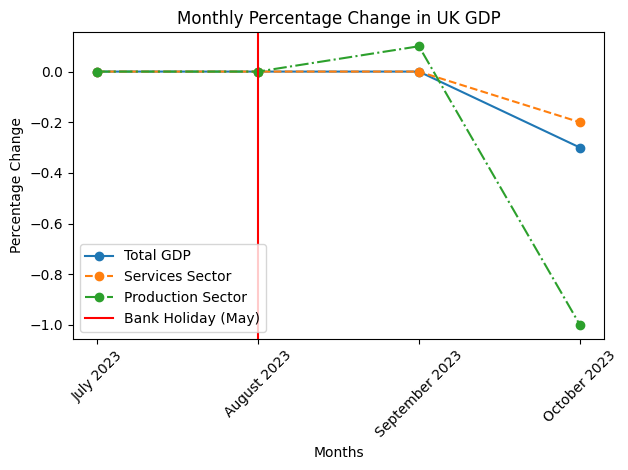

{'call_tool': {'messages': [FunctionMessage(content="python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Define the data\nmonths = ['July 2023', 'August 2023', 'September 2023', 'October 2023']\n# assume zero growth for months without specific info\nmonthly_gdp_changes = [0, 0, 0, -0.3] # October has a decrease of 0.3%\nservices_changes = [0, 0, 0, -0.2] # October has a decrease of 0.2%\nproduction_changes = [0, 0, 0.1, -1.0] # Latest quarter has a decrease of 1.0%, previous quarter had an increase of 0.1%\n\n# Plot the data\nfig, ax = plt.subplots()\nax.plot(months, monthly_gdp_changes, label='Total GDP', marker='o')\nax.plot(months, services_changes, label='Services Sector', marker='o', linestyle='--')\nax.plot(months, production_changes, label='Production Sector', marker='o', linestyle='-.')\n\n# Highlight the additional bank holiday in May\nplt.axvline(x=1, color='red', linestyle='-', label='Bank Holiday (May)')\n\n# Titles and labels\nplt.t

{'Researcher': {'messages': [HumanMessage(content="To generate accurate data for the chart, we need to extract key information about LangChain from the search results. We'll look for details such as the features of LangChain, its uses, and any numerical data that could be represented in a chart. I'll parse through the search results to identify relevant information.\n\nFrom the provided search results, we can extract the following key points about LangChain:\n\n1. LangChain is an open-source framework designed to simplify the creation of applications using large language models (LLMs).\n2. The framework includes a pipeline where a user asks a question to the language model, which then does a similarity search in a vector database to fetch relevant information.\n3. Features of LangChain include the ability to set up the environment easily, installation through pip, and initializing an LLM with a specified temperature for response accuracy.\n4. LangChain allows for the entire lifecycle o

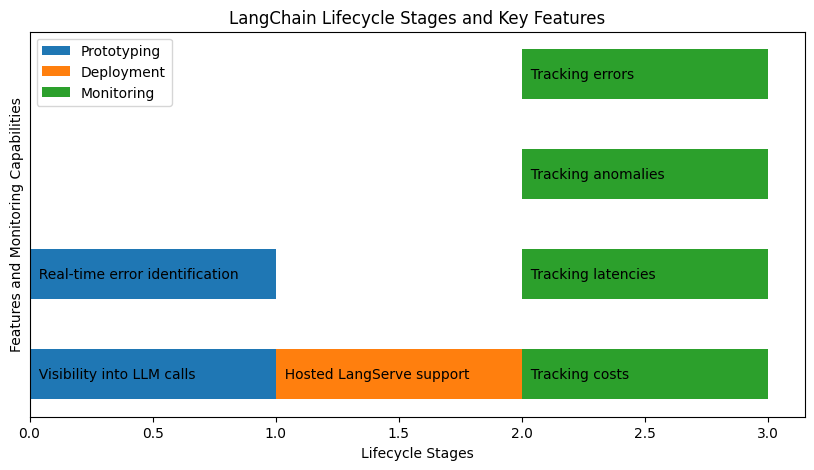

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for chart\\nstages_features = {\\n    \'Prototyping\': [\'Visibility into LLM calls\', \'Real-time error identification\'],\\n    \'Deployment\': [\'Hosted LangServe support\'],\\n    \'Monitoring\': [\'Tracking costs\', \'Tracking latencies\', \'Tracking anomalies\', \'Tracking errors\']\\n}\\n\\n# Create a horizontal bar chart\\nplt.figure(figsize=(10, 5))\\n\\n# Add stages to the chart\\nfor i, (stage, features) in enumerate(stages_features.items()):\\n    plt.barh(range(len(features)), [1]*len(features), left=i, height=0.5, label=stage)\\n\\n    # Add feature names as text\\n    for j, feature in enumerate(features):\\n        plt.text(i, j, \'  \' + feature, va=\'center\')\\n\\n# Set labels and title\\nplt.xlabel(\'Lifecycle Stages\')\\nplt.ylabel(\'Features and Monitoring Capabilities\')\\nplt.title(\'LangChain Lifecycl

{'Researcher': {'messages': [HumanMessage(content='Based on the search results, here is the information that can be used to create a business plan:\n\n1. Conduct market research: Understand your target market and industry.\n2. Write the executive summary: Include your business concept, financial features, financial requirements, current business position, major achievements, and future plans.\n3. Write a company description: Describe who you are, what you plan to do, and why your business is a good investment.\n4. Outline your marketing and sales plan: Explain how you will attract and retain customers.\n5. Detail your operations plan: Outline the workflows and processes needed to run your business.\n6. Financial projections and requirements: Include income statements, balance sheets, cash flow statements, and explain any funding requirements.\n\nThis information should help in creating a well-rounded business plan. Please use this data to generate the chart or report as needed.', name=

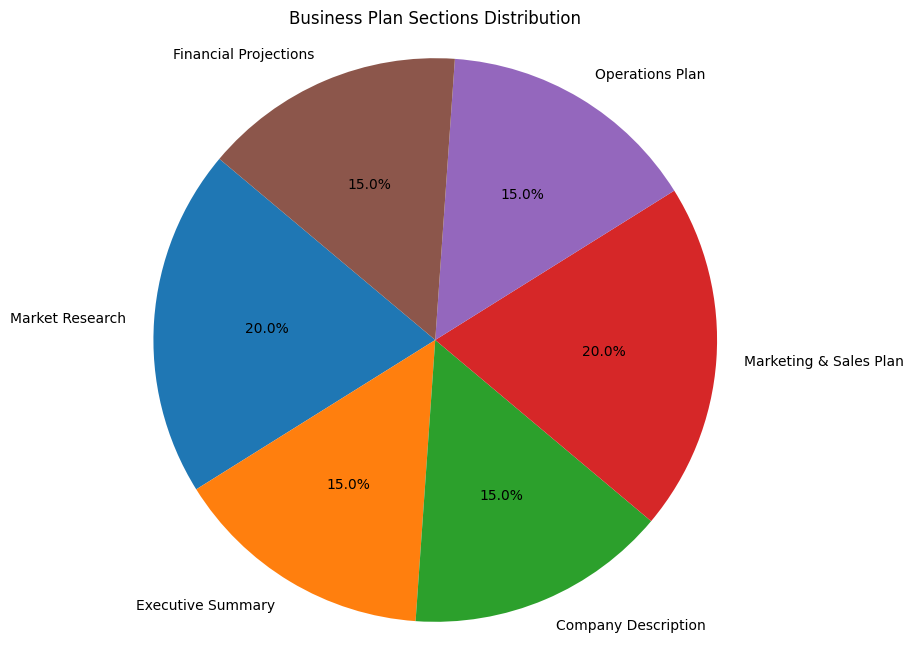

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{\n  "code": "import matplotlib.pyplot as plt\\n\\n# Since the user\'s request is about creating a business plan and not presenting specific data,\\n# we will create a simple pie chart that represents the sections of a business plan.\\n\\n# Define the sections of the business plan and their estimated proportion of importance\\nsections = [\'Market Research\', \'Executive Summary\', \'Company Description\', \'Marketing & Sales Plan\', \'Operations Plan\', \'Financial Projections\']\\nsize = [20, 15, 15, 20, 15, 15]\\n\\n# Create a pie chart\\nplt.figure(figsize=(8, 8))\\nplt.pie(size, labels=sections, autopct=\'%1.1f%%\', startangle=140)\\nplt.title(\'Business Plan Sections Distribution\')\\nplt.axis(\'equal\')  # Equal aspect ratio ensures that pie is drawn as a circle.\\n\\n# Display the pie chart\\nplt.show()"\n}\n', 'name': 'python_repl'}}, name='Chart Generator')], 'sender'

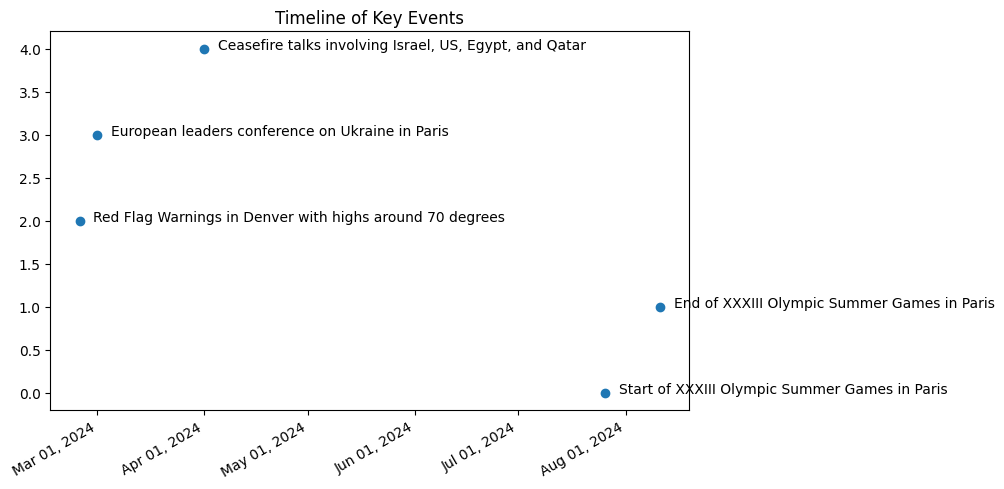

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport matplotlib.dates as mdates\\nfrom datetime import datetime\\n\\n# Create a list of dates and corresponding events\\nevents = [\\n    (datetime(2024, 7, 26), \'Start of XXXIII Olympic Summer Games in Paris\'),\\n    (datetime(2024, 8, 11), \'End of XXXIII Olympic Summer Games in Paris\'),\\n    (datetime(2024, 2, 25), \'Red Flag Warnings in Denver with highs around 70 degrees\'),\\n    # Date for the conference in Paris is not provided, assuming a placeholder date\\n    (datetime(2024, 3, 1), \'European leaders conference on Ukraine in Paris\'),\\n    # Date for the ceasefire talks is not provided, assuming a placeholder date\\n    (datetime(2024, 4, 1), \'Ceasefire talks involving Israel, US, Egypt, and Qatar\')\\n]\\n\\ndates = [event[0] for event in events]\\nevent_labels = [event[1] for event in events]\\n\\n# Create the plot

{'Researcher': {'messages': [HumanMessage(content="The search results provided do not contain the specific current market price for alpaca fiber or wool. The closest related content is from a fiber processing mill that specializes in alpaca and sheep's wool, but it does not provide pricing information.\n\nGiven the search results obtained, we cannot generate the chart data. Further information or a different approach to obtaining the current market price for alpaca fiber and wool is needed to proceed.", name='Researcher')], 'sender': 'Researcher'}}
----
{'Chart Generator': {'messages': [HumanMessage(content="In this case, if we don't have direct access to current market prices for alpaca fiber or wool, we might be able to find the information by looking into commodity market reports, agricultural data, or industry publications that may provide pricing information. This data might be available through specialized databases, agricultural market news services, or by contacting industry as

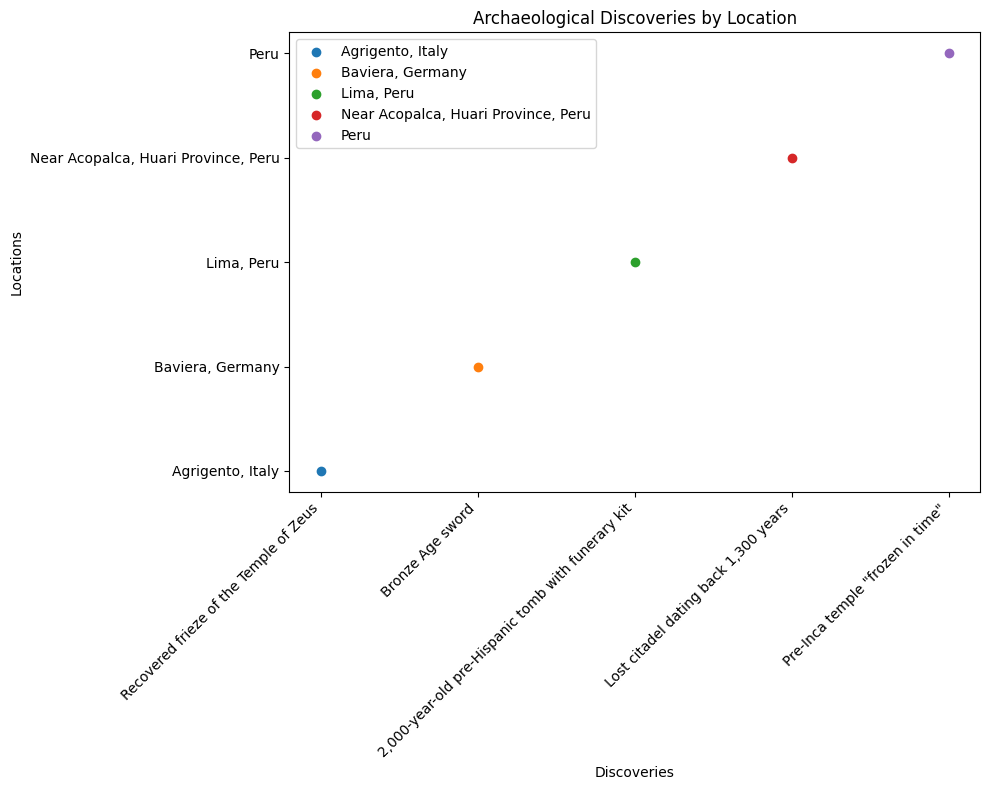

{'call_tool': {'messages': [FunctionMessage(content='python_repl response: Succesfully executed:\n```python\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# Data\narchaeological_data = [\n    {\'Location\': \'Agrigento, Italy\', \'Discovery\': \'Recovered frieze of the Temple of Zeus\'},\n    {\'Location\': \'Baviera, Germany\', \'Discovery\': \'Bronze Age sword\'},\n    {\'Location\': \'Lima, Peru\', \'Discovery\': \'2,000-year-old pre-Hispanic tomb with funerary kit\'},\n    {\'Location\': \'Near Acopalca, Huari Province, Peru\', \'Discovery\': \'Lost citadel dating back 1,300 years\'},\n    {\'Location\': \'Peru\', \'Discovery\': \'Pre-Inca temple "frozen in time"\'}\n]\n\ndf = pd.DataFrame(archaeological_data)\n\n# Plot\nplt.figure(figsize=(10, 8))\nlocations = df[\'Location\'].unique()\nfor loc in locations:\n    discoveries = df[df[\'Location\'] == loc][\'Discovery\'].tolist()\n    y = [loc] * len(discoveries)\n    plt.scatter(discoveries, y, label=loc)\n\nplt.xlabel(\'

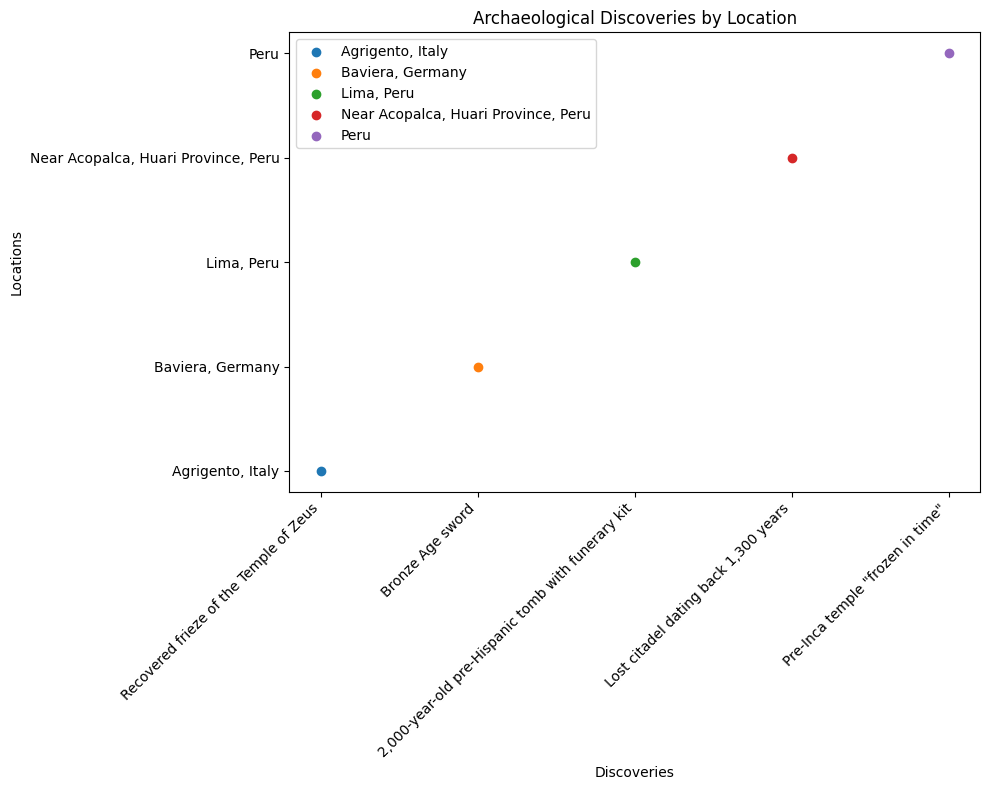

{'Chart Generator': {'messages': [HumanMessage(content='It seems there was a technical issue displaying the chart. Let me try generating the chart again.', additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport pandas as pd\\n\\n# Data\\narchaeological_data = [\\n    {\'Location\': \'Agrigento, Italy\', \'Discovery\': \'Recovered frieze of the Temple of Zeus\'},\\n    {\'Location\': \'Baviera, Germany\', \'Discovery\': \'Bronze Age sword\'},\\n    {\'Location\': \'Lima, Peru\', \'Discovery\': \'2,000-year-old pre-Hispanic tomb with funerary kit\'},\\n    {\'Location\': \'Near Acopalca, Huari Province, Peru\', \'Discovery\': \'Lost citadel dating back 1,300 years\'},\\n    {\'Location\': \'Peru\', \'Discovery\': \'Pre-Inca temple \\"frozen in time\\"\'}\\n]\\n\\ndf = pd.DataFrame(archaeological_data)\\n\\n# Plot\\nplt.figure(figsize=(10, 8))\\nlocations = df[\'Location\'].unique()\\nfor loc in locations:\\n    discoveries = df[df[\'Location\

{'Chart Generator': {'messages': [HumanMessage(content="The previous period's revenue was approximately $3.83 billion.", name='Chart Generator')], 'sender': 'Chart Generator'}}
----
{'Researcher': {'messages': [HumanMessage(content="To provide accurate data for the chart generator, could you please specify the context or additional details surrounding the figure you've provided? For instance, are you looking for a comparison of this period's revenue with the previous period's, or do you need a trend analysis over multiple periods? Also, please clarify which company or entity's revenue you are referring to.", name='Researcher')], 'sender': 'Researcher'}}
----
{'Chart Generator': {'messages': [HumanMessage(content="It seems there might be a misunderstanding, as no specific revenue figure or context has been provided yet. To generate a meaningful chart, I would need the following details:\n\n1. The specific revenue figures you'd like to be visualized.\n2. The time period these figures cov

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import requests\\nfrom bs4 import BeautifulSoup\\n\\n# Function to scrape data from the International Mathematical Olympiad official results\\ndef get_imo_results(year):\\n    url = f\'https://www.imo-official.org/year_individual_ranks.aspx?year={year}\'\\n    response = requests.get(url)\\n    if response.status_code == 200:\\n        soup = BeautifulSoup(response.content, \'html.parser\')\\n        # Find the table with results\\n        table = soup.find(\'table\', {\'class\': \'results\'})\\n        if table:\\n            # Extract the rows of the table\\n            rows = table.find_all(\'tr\')\\n            gold_count = 0\\n            # Iterate over each row to find participants from the United States\\n            for row in rows:\\n                cells = row.find_all(\'td\')\\n                if len(cells) > 4 and \'USA\' in cells[3].text:\\n               

{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import datetime\\n\\ndef current_year():\\n    return datetime.datetime.now().year\\n\\n# Print the current year\\nprint(current_year())\\n"}', 'name': 'python_repl'}}, name='Chart Generator')], 'sender': 'Chart Generator'}}
----
{'call_tool': {'messages': [FunctionMessage(content='python_repl response: Succesfully executed:\n```python\nimport datetime\n\ndef current_year():\n    return datetime.datetime.now().year\n\n# Print the current year\nprint(current_year())\n\n```\nStdout: NameError("name \'datetime\' is not defined")', name='python_repl')]}}
----
{'Chart Generator': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"code":"import datetime\\n\\ndef current_year():\\n    return datetime.datetime.now().year\\n\\n# Print the current year\\nprint(current_year())\\n"}', 'name': 'python_repl'}}, name='Chart Generator')], 'send

GraphRecursionError: Recursion limit of 150 reachedwithout hitting a stop condition. You can increase the limitby setting the `recursion_limit` config key.

In [64]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
):
    print(s)
    print("----")